In [1]:
import torch
from torch.nn.functional import mse_loss
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import matplotlib as mpl
import pandas as pd

from model import vdm_model, networks
from utils import compute_pk
from data import constants

device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
plt.style.use(['science', 'vibrant'])
mpl.rcParams['figure.dpi'] = 300

In [4]:
def load_model(dataset = 'Astrid',
        cropsize = 256,
        gamma_min = -13.3,
        gamma_max = 13.3,
        embedding_dim = 48,
        norm_groups = 8,
        use_fourier_features = False,
        add_attention = True,
        noise_schedule = 'learned_linear',
        n_blocks = 4
):
    vdm = vdm_model.LightVDM(
            score_model=networks.UNetVDM(
                gamma_min=gamma_min,
                gamma_max=gamma_max,
                embedding_dim=embedding_dim,
                norm_groups=norm_groups,
                n_blocks=n_blocks,
                add_attention=add_attention,
                use_fourier_features=use_fourier_features
            ),
            dataset=dataset,
            gamma_min=gamma_min,
            gamma_max=gamma_max,
            image_shape=(1,cropsize,cropsize),
            noise_schedule=noise_schedule,
        )
    vdm = vdm.to(device=device)
    vdm = vdm.eval()
    
    ckpt = 'ckpt_path'
    state_dict=torch.load(ckpt)["state_dict"]
    vdm.load_state_dict(state_dict)
    return vdm.eval()

In [5]:
vdm = load_model()

In [6]:
# Load data
mass_mstar = np.load('Maps_Mstar_Astrid_1P_z=0.00.npy')
mass_cdm = np.load('Astrid_1P_z=0.00.npy')
mass_mstar = np.log10(mass_mstar+1)
mass_cdm = np.log10(mass_cdm)

mean_input = constants.norms['Astrid'][0]
std_input = constants.norms['Astrid'][1]
mean_target = constants.norms['Astrid'][2]
std_target = constants.norms['Astrid'][3]

mass_mstar_normed = torch.Tensor((mass_mstar - mean_input) / std_input).unsqueeze(1).unsqueeze(1)
mass_cdm_normed = torch.Tensor((mass_cdm - mean_target) / std_target).unsqueeze(1).unsqueeze(1)

In [7]:
# selected indices for each parameter
selected = [[3, 7], [25, 29], [36, 40],]

param_indices = [idx for sublist in selected for idx in sublist]
indices = [idx * 15 for sublist in selected for idx in sublist]

In [8]:
labels = [r'$\Omega_m$', r'$A_\mathrm{SN1}$', r'$A_\mathrm{AGN1}$',]
plot_names = ['Omega_m', 'A_SN1', 'A_AGN1',]
names = ['Omega_m', 'sigma_8', 'A_SN1', 'A_AGN1', 'A_SN2', 'A_AGN2']
params = pd.read_csv('params_1P_Astrid.txt', sep=' ', header=None, names=names)

In [9]:
pks_true = []
for idx in indices:
    field = mass_cdm[idx]
    k, P = compute_pk(10**field[None][None])
    pks_true.append(P)
pks_true = torch.stack(pks_true)

In [10]:
pks_stars = []
for idx in indices:
    field = mass_mstar[idx]
    k, P = compute_pk(10**field[None][None] -1.)
    pks_stars.append(P)
pks_stars = torch.stack(pks_stars)

In [11]:
def generate_samples(conditioning, batch_size=10, n=10):

    star = conditioning[0]
    star_fields = star.expand(batch_size, star.shape[0], star.shape[1], star.shape[2])

    maps = [] # 10 tensors of shape ([10, 1, img_shape, img_shape])
    # draw n samples with the same conditioning
    for _ in range(n):
        sample = vdm.draw_samples(
            conditioning=star_fields,
            batch_size=batch_size,
            n_sampling_steps=vdm.hparams.n_sampling_steps,
            )
        maps.append(sample)
        
    return maps

In [12]:
generated_maps = []
for idx in indices:
    print(idx)
    generated_maps.append(
        torch.vstack(generate_samples(conditioning=mass_mstar_normed[idx].to(device), batch_size=20, n=5))
    )
generated_maps = torch.stack(generated_maps) * std_target + mean_target


45
105
375
435
540
600


In [13]:
pks_generated = []
for samples in generated_maps:
    pks_per_sample = []
    for field in samples:
        k, P_gen  = compute_pk(10**field[None].cpu().numpy())
        pks_per_sample.append(P_gen)
    pks_generated.append(torch.vstack(pks_per_sample))
k = k.detach().cpu()
pks_generated = torch.stack(pks_generated)

In [14]:
import seaborn as sns
from matplotlib.colors import Normalize

In [18]:
colormap = sns.color_palette("flare", as_cmap=True)
norm = Normalize(vmin=0, vmax=2)

In [15]:
k_idx = np.unique(np.arange(len(k))[np.logspace(0,np.log10(len(k)),50).astype(int)])

In [16]:
import matplotlib.patches as mpatches

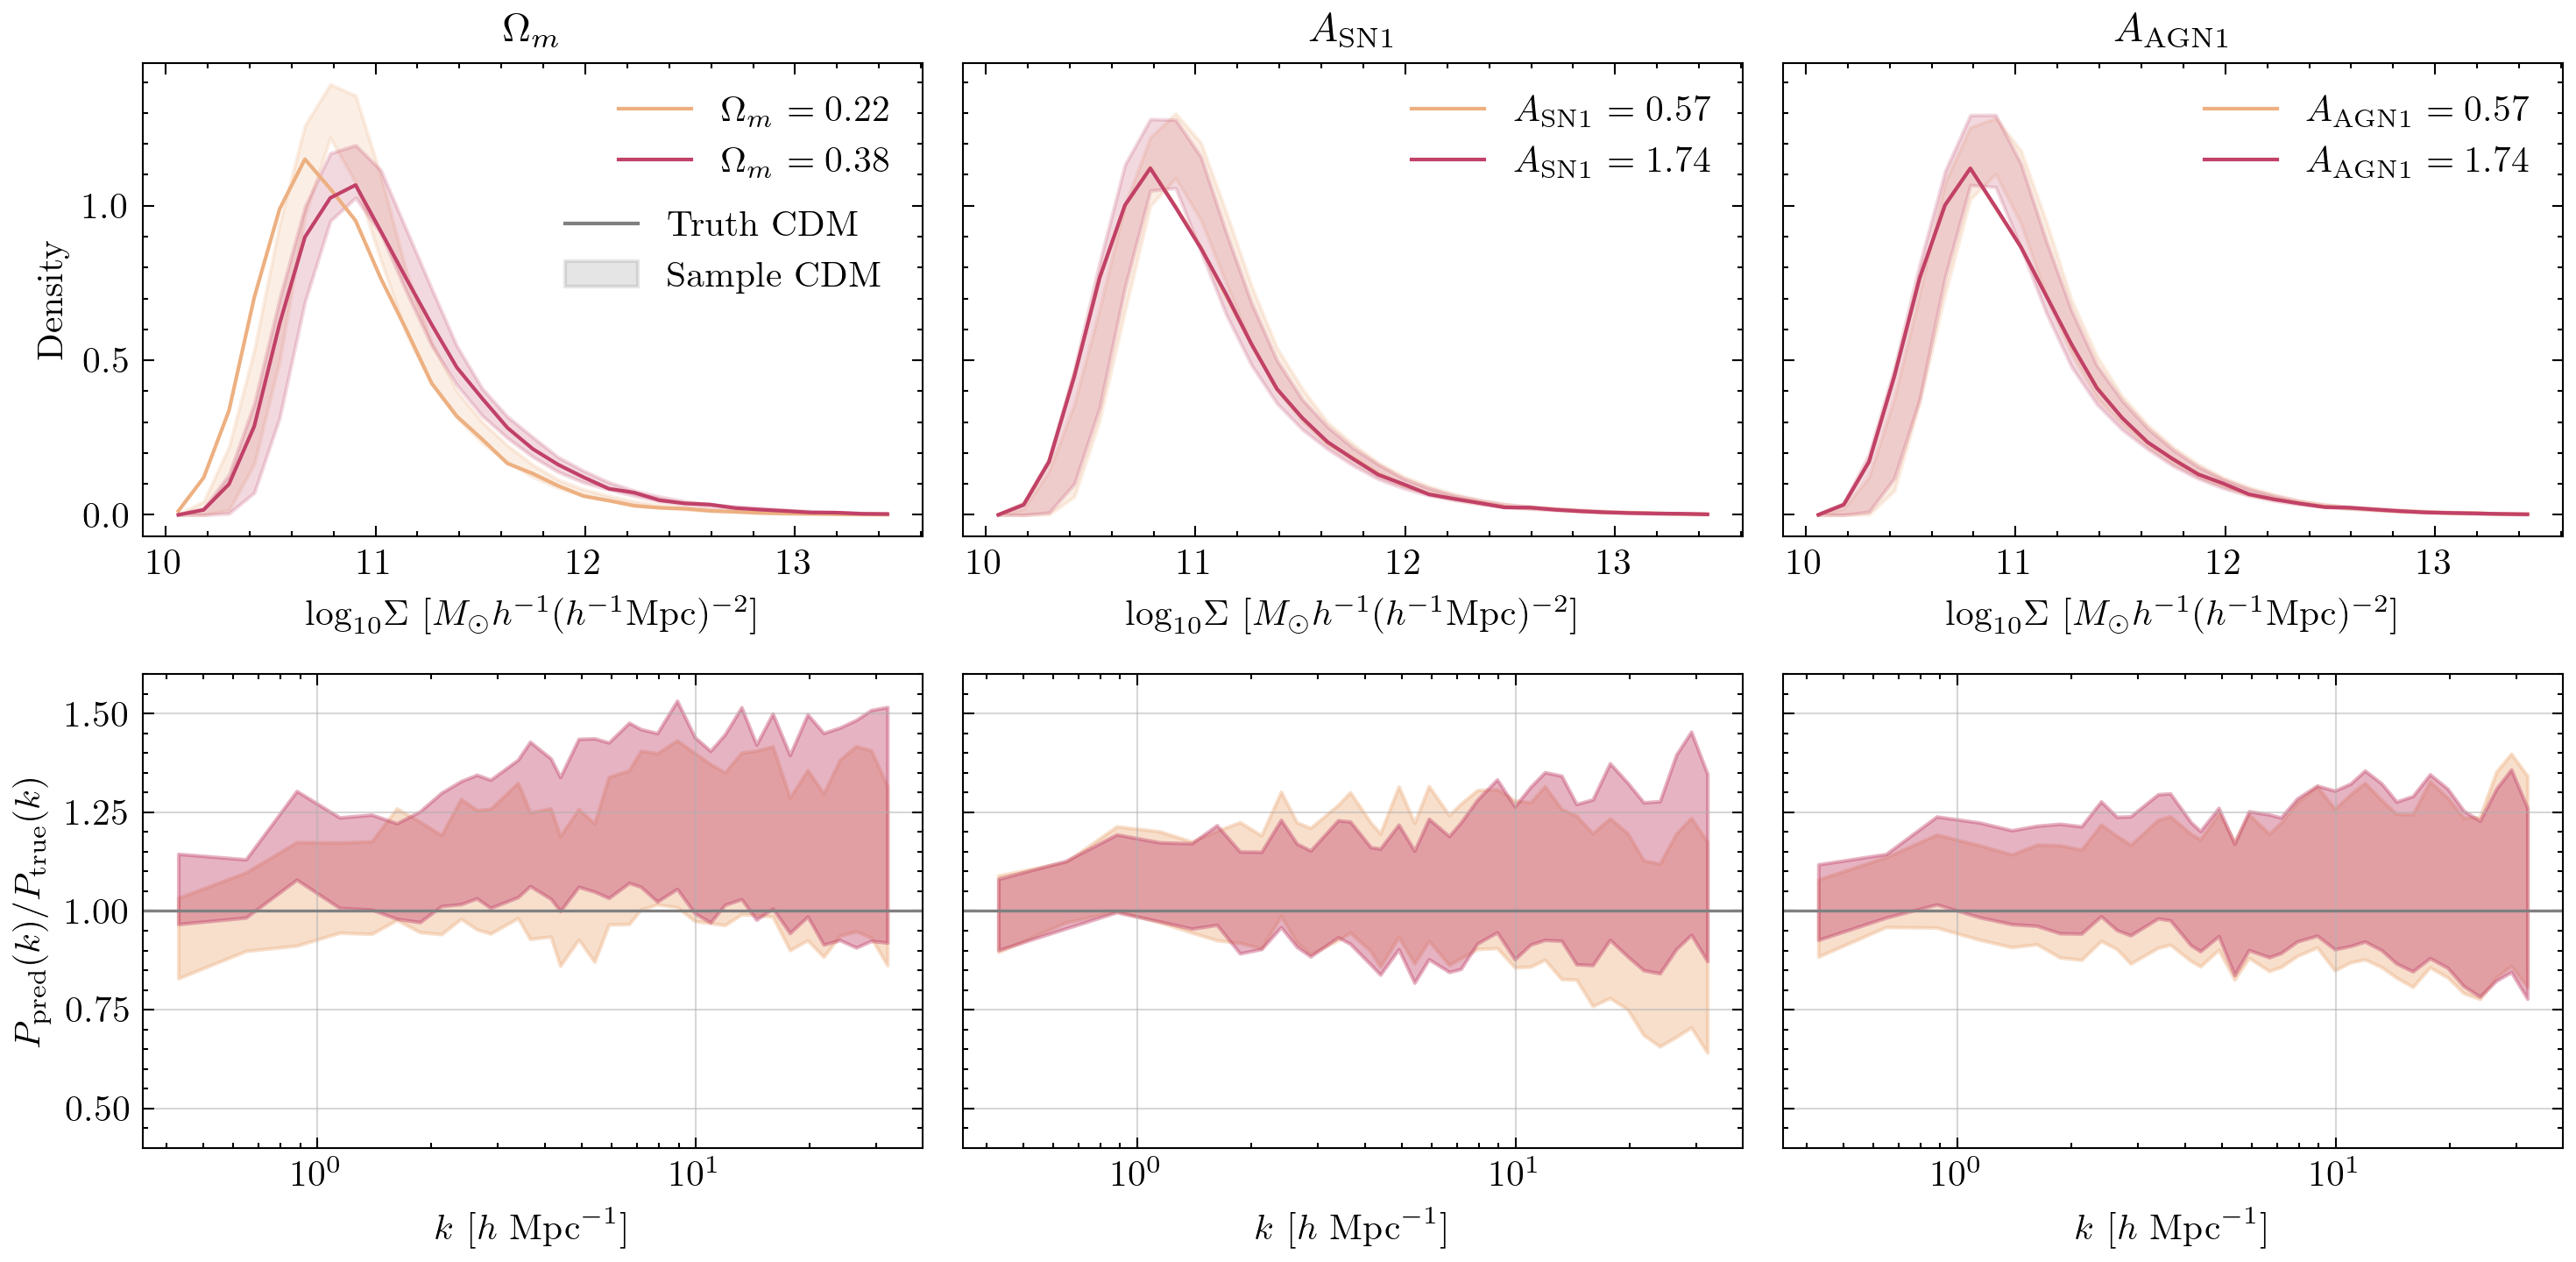

In [19]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10,5), sharey='row')
plt.rcParams.update({
    'axes.titlesize': 11,
    'legend.loc': 'upper right',
    'legend.fontsize': 6
    })


cum_index = 0    
for col in range(3):
    cm=0
    ax[1,col].grid(True,alpha=0.5,)
    for idx in [0,1]:
        color = colormap(norm(cm))
        param_value = params.iloc[param_indices].reset_index().iloc[cum_index][plot_names[col]]
        param_label = f'{labels[col]} $ = {param_value:.2f}$'

        # density pdfs
        cdm_bins = np.linspace(10,13.5,30)
        cdm_bins_c = 0.5*(cdm_bins[1:] + cdm_bins[:-1])
        star_bins = np.linspace(8,12.5,35)
        star_bins_c = 0.5*(star_bins[1:] + star_bins[:-1])
        hist_generated = []
        for i in range(len(generated_maps[cum_index])):
            gen_hist, _ = np.histogram(generated_maps[cum_index][i].squeeze().cpu().numpy().flatten(), bins=cdm_bins, density=True,)
            hist_generated.append(gen_hist)
        ax[0,col].fill_between(
            cdm_bins_c, 
            np.percentile(hist_generated, 10, axis=0), 
            np.percentile(hist_generated, 90, axis=0), 
            color=color,
            label=None,#'Sample CDM',
            alpha=0.2,
        )
        ax[0,col].plot(
            cdm_bins_c,np.histogram(mass_cdm[indices[cum_index]].squeeze().flatten(), bins=cdm_bins, density=True)[0],  
            color=color, 
            label=param_label,
        )

        # pk ratios
        true = pks_true[cum_index]
        avg_pred = torch.mean(pks_generated[cum_index], axis=0)
        std_pred = torch.std(pks_generated[cum_index], axis=0)
        error_ratio = torch.std(pks_generated[cum_index] / true, axis=0)
        ratio = torch.mean(pks_generated[cum_index] / true, axis=0)
        ax[1,col].fill_between(k[k_idx], (ratio-error_ratio)[k_idx], (ratio+error_ratio)[k_idx], color=color, alpha=0.4,)
        ax[1,col].set_xscale('log')
        ax[0,col].set_title(labels[col])
        cm+=1
        cum_index+=1
    ax[1,col].axhline(1, color='black', lw=0.8)
    ax[1,col].set_ylim(0.4,1.6)
    ax[1,col].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
    ax[0,col].set_xlabel(r'$\mathrm{log}_{10} \Sigma$ ' + '$[M_{\odot} h^{-1} ( h^{-1} \mathrm{Mpc})^{-2}]$')
    legend = ax[0,col].legend(fontsize=10)
    if col == 0:
        gray_line = plt.Line2D([0], [0], color='gray', lw=1, label='Truth CDM')
        gray_patch = mpatches.Patch(edgecolor='gray', facecolor='gray', label='Sample CDM', alpha=0.2,)
        secondary_legend = ax[0,col].legend(handles=[gray_line, gray_patch], loc='center right', bbox_to_anchor=(0.99,0.6), fontsize=10)
        ax[0,col].add_artist(legend)


ax[1,0].set_ylabel(r'$P_{\mathrm{pred}}(k)/P_{\mathrm{true}}(k)$')
ax[0,0].set_ylabel(r'Density')
plt.tight_layout()